In [156]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from micromlgen import port
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [82]:
def load_data_from_directory(directory):
    data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            data.append(df)
            labels.append(directory)  # Zakładamy, że nazwa folderu to etykieta
    return data, labels

In [83]:
#lewo_data, lewo_labels = load_data_from_directory('lewo')
#przod_data, przod_labels = load_data_from_directory('przod')
avada_data, avada_labels = load_data_from_directory('avada')
lumos_data, lumos_labels = load_data_from_directory('lumos')
alohomora_data, alohomora_labels = load_data_from_directory('alohomora')
wingardium_data, wingardium_labels = load_data_from_directory('wingardium')

In [121]:
def brief_plot(data):
    rows = len(data) // 4
    fig, ax = plt.subplots(rows,3,figsize=(16,12))
    for i in range(rows):
        for j in range(3):
            ax[i,j].plot(data[3*i+j]["time"], data[3*i+j].iloc[:,1:])

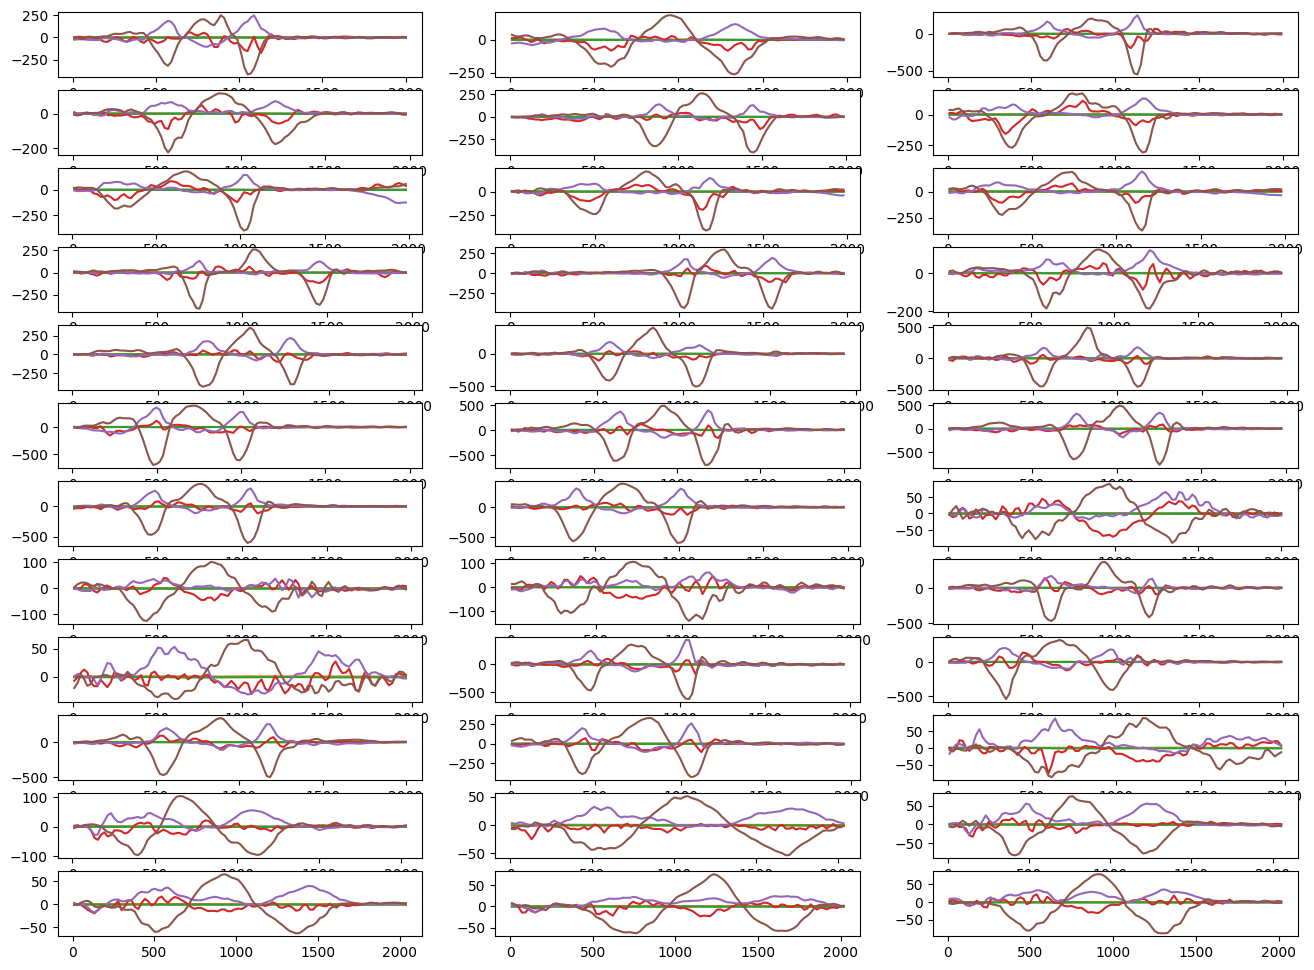

In [123]:
brief_plot(avada_data)

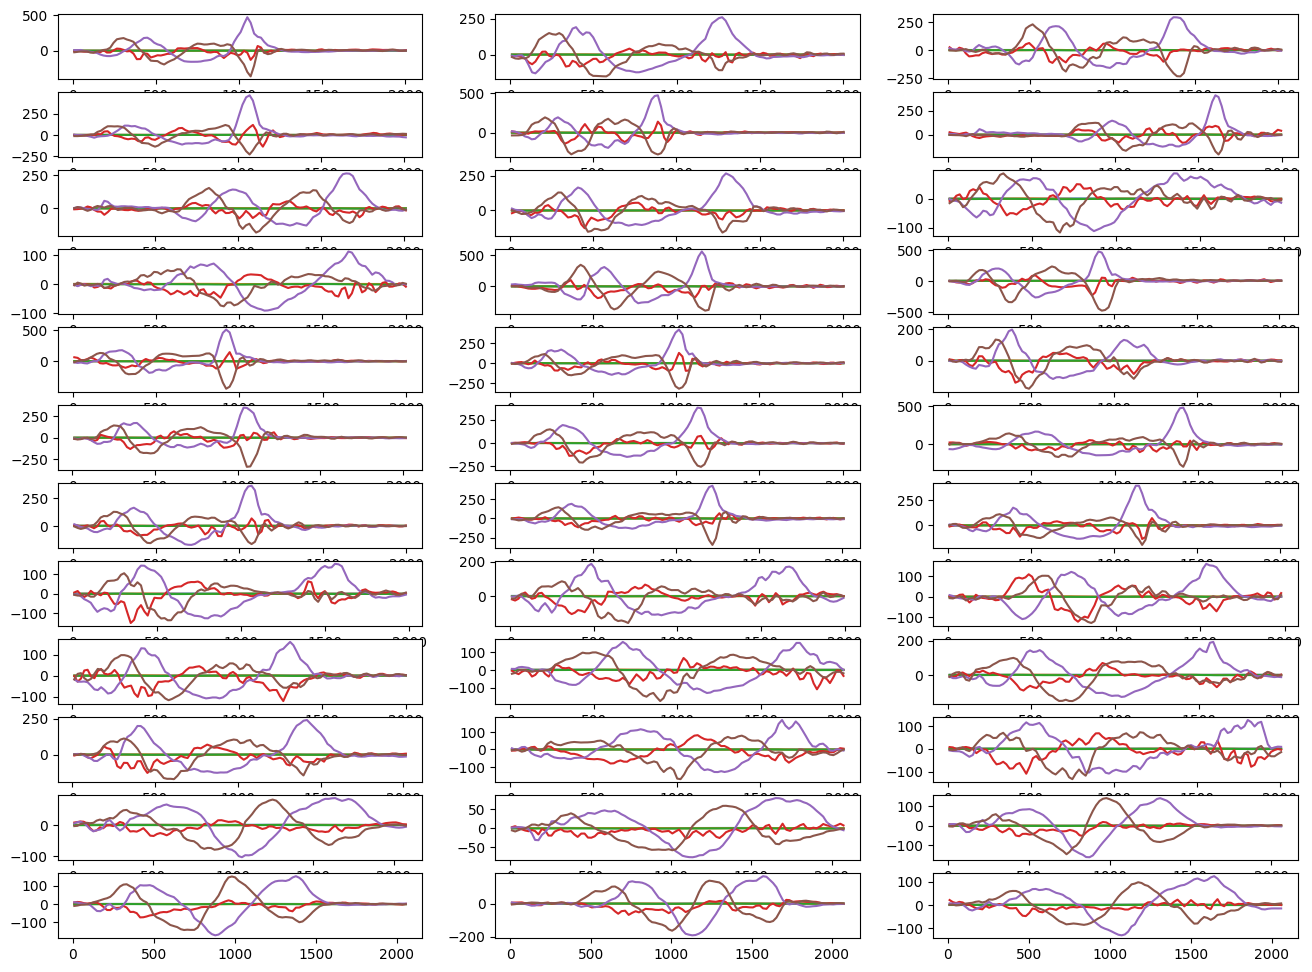

In [126]:
brief_plot(alohomora_data)

In [219]:
X = avada_data + lumos_data + alohomora_data + wingardium_data # + lewo_data + przod_data
y = avada_labels + lumos_labels + alohomora_labels + wingardium_labels # + lewo_labels + przod_labels

In [135]:
X = [item.flatten() for item in np.array(X)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:
a = [None] + list(range(1, 23, 3))

In [194]:
param_grid= {
    'n_estimators': list(range(15,25,2)),
    'max_depth': a,
    'min_samples_leaf': [1,5,10],
    'min_samples_split': [2,4,6]
            }

In [195]:
model = RandomForestClassifier(random_state=42)
grid_search_cv = GridSearchCV(model, param_grid, cv=3,scoring='accuracy',return_train_score=True)
#model.fit(X_train, y_train)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 4, 7, 10, 13, 16, 19, 22],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [15, 17, 19, 21, 23]},
             return_train_score=True, scoring='accuracy')

In [199]:
grid_search_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 21}

In [200]:
grid_search_cv.best_score_

np.float64(0.9097222222222222)

In [208]:
model = grid_search_cv.best_estimator_
unknown_X, unknown_Y = load_data_from_directory('unknown2')
unknown_X = [item.flatten() for item in np.array(unknown_X)]

In [209]:
model.predict(unknown_X)

array(['lumos', 'lumos', 'lumos', 'lumos', 'lumos', 'wingardium',
       'wingardium', 'wingardium', 'wingardium', 'alohomora', 'avada',
       'avada', 'avada', 'avada', 'avada', 'alohomora', 'alohomora',
       'avada', 'alohomora', 'alohomora', 'alohomora', 'alohomora',
       'alohomora', 'alohomora', 'alohomora'], dtype='<U10')

In [212]:

# Prawdopodobieństwa przewidywań
proba = model.predict_proba(unknown_X)
print("Prediction probabilities:")
print(proba)


Prediction probabilities:
[[0.04761905 0.19047619 0.52380952 0.23809524]
 [0.14285714 0.14285714 0.52380952 0.19047619]
 [0.14285714 0.14285714 0.42857143 0.28571429]
 [0.19047619 0.0952381  0.52380952 0.19047619]
 [0.23809524 0.14285714 0.42857143 0.19047619]
 [0.04761905 0.04761905 0.         0.9047619 ]
 [0.04761905 0.         0.0952381  0.85714286]
 [0.14285714 0.         0.         0.85714286]
 [0.         0.19047619 0.04761905 0.76190476]
 [0.47619048 0.23809524 0.14285714 0.14285714]
 [0.04761905 0.66666667 0.04761905 0.23809524]
 [0.0952381  0.80952381 0.0952381  0.        ]
 [0.0952381  0.71428571 0.0952381  0.0952381 ]
 [0.04761905 0.80952381 0.04761905 0.0952381 ]
 [0.0952381  0.80952381 0.0952381  0.        ]
 [0.85714286 0.0952381  0.04761905 0.        ]
 [0.33333333 0.33333333 0.14285714 0.19047619]
 [0.23809524 0.33333333 0.28571429 0.14285714]
 [0.42857143 0.42857143 0.0952381  0.04761905]
 [0.52380952 0.28571429 0.14285714 0.04761905]
 [0.61904762 0.19047619 0.19047619

In [236]:
class_map = {label: i for i, label in enumerate(set(y))}  # Mapuj unikalne etykiety na indeksy

class_map

{'lumos': 0, 'alohmora': 1, 'wingardium': 2, 'avada': 3}

In [235]:
c_code = port(model, classmap={v: k for k, v in class_map.items()})

with open("./arduCode/mainCode/model_with_labels.h", "w") as f:
    f.write(c_code)